In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In this challenge, you are required to improve your model with respect to its prediction performance

## Steps

1. Load the houseprices data from Thinkful's database.
* Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But, make sure that your work is satisfactory.
* Now, split your data into train and test sets where 20% of the data resides in the test set.
* Build several linear regression models including lasso, ridge, or elastic net, and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one.
* Evaluate your best model on the test set.
* So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [2]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

import warnings

warnings.filterwarnings("ignore")
import config

<IPython.core.display.Javascript object>

In [3]:
postgres_user = config.user
postgres_pw = config.password
postgres_host = config.host
postgres_port = config.port
postgres_db = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

df = pd.read_sql_query("select * from houseprices", con=engine)

# No need for an open connection,
# because you're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

In [5]:
df.shape

(1460, 81)

<IPython.core.display.Javascript object>

In [10]:
df_num = df.select_dtypes(include=["float64", "int64"])
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   lotfrontage    1201 non-null   float64
 3   lotarea        1460 non-null   int64  
 4   overallqual    1460 non-null   int64  
 5   overallcond    1460 non-null   int64  
 6   yearbuilt      1460 non-null   int64  
 7   yearremodadd   1460 non-null   int64  
 8   masvnrarea     1452 non-null   float64
 9   bsmtfinsf1     1460 non-null   int64  
 10  bsmtfinsf2     1460 non-null   int64  
 11  bsmtunfsf      1460 non-null   int64  
 12  totalbsmtsf    1460 non-null   int64  
 13  firstflrsf     1460 non-null   int64  
 14  secondflrsf    1460 non-null   int64  
 15  lowqualfinsf   1460 non-null   int64  
 16  grlivarea      1460 non-null   int64  
 17  bsmtfullbath   1460 non-null   int64  
 18  bsmthalf

<IPython.core.display.Javascript object>

In [13]:
df.isnull().sum().sort_values(ascending=False).head(20)

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
lotfrontage      259
garagecond        81
garagetype        81
garageyrblt       81
garagefinish      81
garagequal        81
bsmtexposure      38
bsmtfintype2      38
bsmtfintype1      37
bsmtcond          37
bsmtqual          37
masvnrarea         8
masvnrtype         8
electrical         1
utilities          0
dtype: int64

<IPython.core.display.Javascript object>

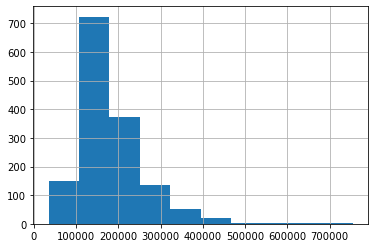

<IPython.core.display.Javascript object>

In [14]:
df.saleprice.hist()

In [22]:
mortlist = [
    [1, 2006, 6.285],
    [2, 2006, 6.409],
    [3, 2006, 6.476],
    [4, 2006, 6.628],
    [5, 2006, 6.745],
    [6, 2006, 6.825],
    [7, 2006, 6.887],
    [8, 2006, 6.636],
    [9, 2006, 6.496],
    [10, 2006, 6.465],
    [11, 2006, 6.356],
    [12, 2006, 6.223],
    [1, 2007, 6.326],
    [2, 2007, 6.377],
    [3, 2007, 6.273],
    [4, 2007, 6.357],
    [5, 2007, 6.384],
    [6, 2007, 6.736],
    [7, 2007, 6.855],
    [8, 2007, 6.971],
    [9, 2007, 6.827],
    [10, 2007, 6.722],
    [11, 2007, 6.562],
    [12, 2007, 6.526],
    [1, 2008, 6.244],
    [2, 2008, 6.409],
    [3, 2008, 6.624],
    [4, 2008, 6.540],
    [5, 2008, 6.572],
    [6, 2008, 6.876],
    [7, 2008, 6.922],
    [8, 2008, 7.008],
    [9, 2008, 6.646],
    [10, 2008, 6.839],
    [11, 2008, 6.686],
    [12, 2008, 6.025],
    [1, 2009, 5.786],
    [2, 2009, 5.809],
    [3, 2009, 5.653],
    [4, 2009, 5.469],
    [5, 2009, 5.473],
    [6, 2009, 5.922],
    [7, 2009, 5.712],
    [8, 2009, 5.678],
    [9, 2009, 5.514],
    [10, 2009, 5.401],
    [11, 2009, 5.329],
    [12, 2009, 5.337],
    [1, 2010, 5.485],
    [2, 2010, 5.396],
    [3, 2010, 5.321],
    [4, 2010, 5.405],
    [5, 2010, 5.242],
    [6, 2010, 5.130],
    [7, 2010, 4.957],
]

<IPython.core.display.Javascript object>

In [54]:
df["30yrmort_rate"] = 0.00

<IPython.core.display.Javascript object>

In [55]:
for i in range(df.shape[0]):
    for j in range(len(mortlist)):
        if (df.yrsold[i] == mortlist[j][1]) & (df.mosold[i] == mortlist[j][0]):
            df["30yrmort_rate"][i] = mortlist[j][2]



<IPython.core.display.Javascript object>

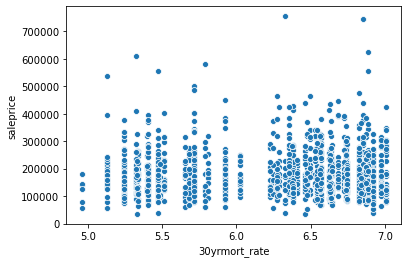

<IPython.core.display.Javascript object>

In [58]:
sns.scatterplot(x="30yrmort_rate", y="saleprice", data=df)
plt.show()

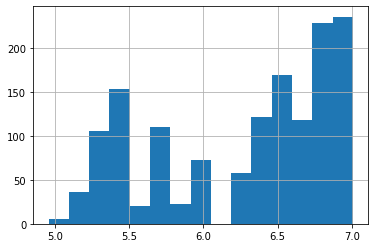

<IPython.core.display.Javascript object>

In [61]:
df["30yrmort_rate"].hist(bins=15)

In [62]:
df = pd.concat(
    [df, pd.get_dummies(df.condition1, prefix="condition1", drop_first=True)], axis=1
)
df = pd.concat(
    [df, pd.get_dummies(df.condition2, prefix="condition2", drop_first=True)], axis=1
)
dummy_cols = list(
    pd.get_dummies(df.condition1, prefix="condition1", drop_first=True).columns
)
dummy_cols = dummy_cols + list(
    pd.get_dummies(df.condition2, prefix="condition2", drop_first=True).columns
)

<IPython.core.display.Javascript object>

In [67]:
X = df[
    [
        "overallqual",
        "grlivarea",
        "garagecars",
        "totalbsmtsf",
        "30yrmort_rate",
    ]
    + dummy_cols
]

<IPython.core.display.Javascript object>

In [68]:
droplist = [
    "condition1_PosN",
    "condition1_RRAn",
    "condition1_Feedr",
    "condition1_PosA",
    "condition1_RRAe",
    "condition1_RRNe",
    "condition1_RRNn",
    "condition2_Feedr",
    "condition2_Norm",
    "condition2_PosA",
    "condition2_RRAe",
    "condition2_RRAn",
    "condition2_RRNn",
]

<IPython.core.display.Javascript object>

In [69]:
df["totalsf"] = df["totalbsmtsf"] + df["firstflrsf"] + df["secondflrsf"]
df["inter_qual_sf"] = df["totalsf"] * df["overallqual"]
X = X.drop(droplist, axis=1)
y = np.log1p(df.saleprice)
X = pd.concat([X, df["totalsf"], df["inter_qual_sf"]], axis=1)
X = X.drop(columns=["totalbsmtsf"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [70]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

<IPython.core.display.Javascript object>

In [71]:
print("R-squared for training: {}".format(model.score(X_train, y_train)))
print("-------Test Set Stats-------")
print("R-squared for testing: {}".format(model.score(X_test, y_test)))
print("MAE: {}".format(mean_absolute_error(y_test, y_pred_test)))
print("MSE: {}".format(mse(y_test, y_pred_test)))
print("RMSE: {}".format(rmse(y_test, y_pred_test)))
print("MAPE: {}".format(np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100))

R-squared for training: 0.8058361787443409
-------Test Set Stats-------
R-squared for testing: 0.8270812436226724
MAE: 0.1285019679845263
MSE: 0.03166197125711756
RMSE: 0.1779381107495456
MAPE: 1.0840428391488137


<IPython.core.display.Javascript object>

In [72]:
alphas = [np.power(10.0, p) for p in np.arange(-10, 40, 1)]
model_lasso = LassoCV(alphas=alphas, cv=5)
model_lasso.fit(X_train, y_train)

y_pred = model_lasso.predict(X_test)
print("Best alpha: {}".format(model_lasso.alpha_))
print("R-squared for training: {}".format(model_lasso.score(X_train, y_train)))
print("-------Test Set Stats-------")
print("R-squared for testing: {}".format(model_lasso.score(X_test, y_test)))
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))
print("MSE: {}".format(mse(y_test, y_pred)))
print("RMSE: {}".format(rmse(y_test, y_pred)))
print("MAPE: {}".format(np.mean(np.abs((y_test - y_pred) / y_test)) * 100))

Best alpha: 0.001
R-squared for training: 0.8033088199957802
-------Test Set Stats-------
R-squared for testing: 0.825231921853152
MAE: 0.12886359725020835
MSE: 0.03200058792276111
RMSE: 0.17888708148650956
MAPE: 1.086592114794052


<IPython.core.display.Javascript object>

In [73]:
model_ridge = RidgeCV(alphas=alphas, cv=5)
model_ridge.fit(X_train, y_train)

y_pred = model_ridge.predict(X_test)
print("Best alpha: {}".format(model_ridge.alpha_))
print("R-squared for training: {}".format(model_ridge.score(X_train, y_train)))
print("-------Test Set Stats-------")
print("R-squared for testing: {}".format(model_ridge.score(X_test, y_test)))
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))
print("MSE: {}".format(mse(y_test, y_pred)))
print("RMSE: {}".format(rmse(y_test, y_pred)))
print("MAPE: {}".format(np.mean(np.abs((y_test - y_pred) / y_test)) * 100))

Best alpha: 10.0
R-squared for training: 0.8040449194525011
-------Test Set Stats-------
R-squared for testing: 0.8261573163516575
MAE: 0.12851616992499937
MSE: 0.03183114526294207
RMSE: 0.17841285061043688
MAPE: 1.083839689264795


<IPython.core.display.Javascript object>

In [74]:
model_elastic = ElasticNetCV(alphas=alphas, cv=5)
model_elastic.fit(X_train, y_train)

y_pred = model_elastic.predict(X_test)
print("Best alpha: {}".format(model_elastic.alpha_))
print("R-squared for training: {}".format(model_elastic.score(X_train, y_train)))
print("-------Test Set Stats-------")
print("R-squared for testing: {}".format(model_elastic.score(X_test, y_test)))
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))
print("MSE: {}".format(mse(y_test, y_pred)))
print("RMSE: {}".format(rmse(y_test, y_pred)))
print("MAPE: {}".format(np.mean(np.abs((y_test - y_pred) / y_test)) * 100))

Best alpha: 0.001
R-squared for training: 0.8045127385693089
-------Test Set Stats-------
R-squared for testing: 0.8258345336538371
MAE: 0.12874842121520763
MSE: 0.031890247795916454
RMSE: 0.17857840797788643
MAPE: 1.0857655009595566


<IPython.core.display.Javascript object>

In these model's, the national average 30 year mortage rate corresponding to the month and year sold was added as a feature. the improvement to the model was negligalbe.